In [1]:
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
# Suppress lal warning
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

from dingo.gw.result import Result
from dingo.core.utils.plotting import plot_corner_multi

## Tutorial: Inference with DINGO-T1
This tutorial illustrates how to perform inference on the event GW190701_20336 with different detector configurations (H vs. HL. vs HLV) and visualize the resulting posterior distributions.
While 100,000 posterior samples were drawn for the results shown in the paper, we only generate 10,000 samples in this tutorial to speed up inference. This can be easily adjusted in the settings files.

The final plot will look similar to this:

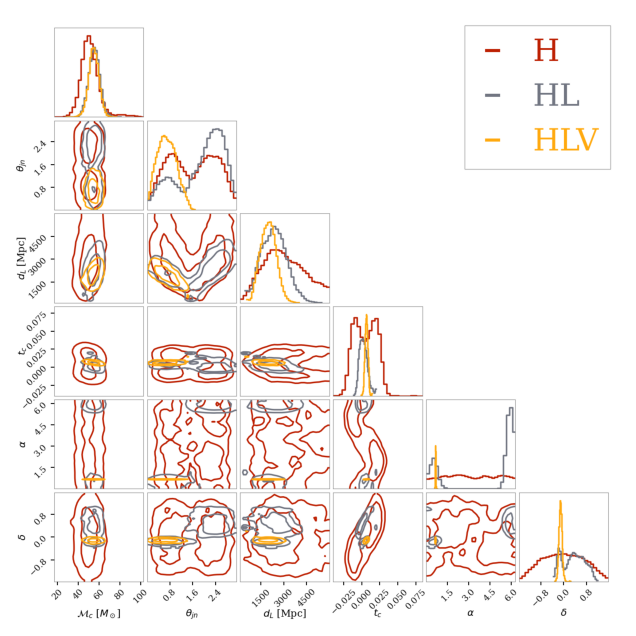

In [2]:
img = Image.open('../00_figures/corner_plot_comparison_GW190701_203306_H_vs_HL_vs_HLV.png')
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off');

### 1. Download model from Zenodo
As a first step, we have to download the DINGO-T1 model from [Zenodo](https://zenodo.org/records/17726076) via:

In [ ]:
!pip install zenodo_get

In [ ]:
%pwd # Check that the models are saved into the folder /02_inference_with_pretrained_models, you might need to adjust the path.

In [ ]:
!zenodo_get 17726076

### 2. Run inference with `dingo_pipe`
Using the `.ini` files in the directory `/events/GW190701_203306`, we can run `dingo_pipe` via:

In [ ]:
!dingo_pipe events/GW190701_203306/H1/GW190701_203306.ini

Depending on the directory where the jupyter server was started, you might need to adjust your path in the `.ini` files and when loading the result.

In [ ]:
result_h = Result(file_name="events/GW190701_203306/H1/result/GW190701_203306_data0_1246048404-56_importance_sampling.hdf5")
result_h.print_summary()

As expected, we obtain a high sample efficiency, since this is a single-detector event with a broad posterior distribution which makes it easier to learn for DINGO-T1. The exact value might deviate from the ones reported in the paper since we do not draw enough samples to obtain a valid estimate and the efficiency will display a certain randomness.

Since we want to compare posteriors across detector configurations, we will run dingo_pipe for HL and HLV as well:

In [ ]:
!dingo_pipe events/GW190701_203306/H1_L1/GW190701_203306.ini

In [ ]:
!dingo_pipe events/GW190701_203306/H1_L1_V1/GW190701_203306.ini

### 3. Load samples and visualize posterior

In [ ]:
result_hl = Result(file_name="events/GW190701_203306/H1_L1/result/GW190701_203306_data0_1246048404-56_importance_sampling.hdf5")
result_hl.print_summary()

In [ ]:
result_hlv = Result(file_name="events/GW190701_203306/H1_L1_V1/result/GW190701_203306_data0_1246048404-56_importance_sampling.hdf5")
result_hlv.print_summary()

In [ ]:
h_samples = result_h.get_pesummary_samples()
hl_samples = result_hl.get_pesummary_samples()
hlv_samples = result_hlv.get_pesummary_samples()

# Subtract trigger time
event_times = [result_h.event_metadata["time_event"], result_hl.event_metadata["time_event"], result_hlv.event_metadata["time_event"]]
assert np.unique(event_times).size == 1
h_samples["geocent_time"] -= event_times[0]
hl_samples["geocent_time"] -= event_times[0]
hlv_samples["geocent_time"] -= event_times[0]

In [ ]:
latex_labels_dict = {"chirp_mass": r"$\mathcal{M}_c$ [$M_\odot$]", "theta_jn": r"$\theta_{jn}$", "luminosity_distance": r"$d_L$ [Mpc]", "geocent_time": r"$t_c$", "ra": r"$\alpha$", "dec": r"$\delta$"}
params = list(latex_labels_dict.keys())
colors = ['#bd1f01', '#717581', '#ffa90e']

# Filename of the corner plot
out_file_name = "corner_plot_comparison_GW190701_203306_H_vs_HL_vs_HLV.png"

fig = plot_corner_multi(
    [h_samples[params], hl_samples[params], hlv_samples[params]],
    weights=[None, None, None],
    labels=["H", "HL", "HLV"],
    filename=out_file_name,
    latex_labels_dict=latex_labels_dict,
    colors=colors,
)

If you want to experiment further by changing the frequency ranges, you can do so my modifying:

**(1) Minimum frequency**:

`minimum-frequency = 50.0` (for all detectors) or `minimum-frequency = {'H1': 30, 'L1': 50, 'V1': 20}` (for individual detectors) (model trained with masking up to $f_\mathrm{min} = 180$Hz)

**(2) Maximum frequency**:

`maximum-frequency = 224.0` (for all detectors) or `maximum-frequency = {'H1': 224, 'L1': 448, 'V1': 896}` (for individual detectors) (model trained with masking as low as $f_\mathrm{max} = 80$Hz)

**(3) PSD notching**:

`suppress = {'V1': [46, 51]}` (model trained with a maximal suppress range of 10 Hz across the full frequency range of [20, 1810] Hz)